## 5: Linear Regression and Train/Test Split
#### Use the 2013_movies.csv data set:

In [165]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import KFold
% matplotlib inline

import statsmodels.api as sm

import warnings
warnings.filterwarnings('ignore')
# from sklearn.linear_model import RidgeCV

In [74]:
df = pd.read_csv('./data/2013_movies.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 7 columns):
Title                 100 non-null object
Budget                89 non-null float64
DomesticTotalGross    100 non-null int64
Director              96 non-null object
Rating                100 non-null object
Runtime               100 non-null int64
ReleaseDate           100 non-null object
dtypes: float64(1), int64(2), object(4)
memory usage: 5.5+ KB


In [75]:
# Let's start with filtering features using p-value:
# est=LinearRegression()
from sklearn import feature_selection as f_select

def pvals(X,y):
    pvals=[] # will be the list of all significant columns' p-values

    for feature in X.columns:
        #get pval on feature by feature basis
        pval=f_select.f_regression(X[[feature]],y) # gets f-value and p-value
    return pvals

### Challenge 1
#### Build a linear model that uses only a constant term (a column of ones) to predict a continuous outcome (like domestic total gross). How can you interpret the results of this model? What does it predict? Make a plot of predictions against actual outcome. Make a histogram of residuals. How are the residuals distributed?

<font color='blue'>Answer:

The constant value feature ("const") does not contribute to the variance in the response at all ($R^2=0$). The intercept is the mean of the response variable, as the mean minimizes the RSE. Therefore, using a constant feature, the model predicts the mean of the response variable.  

From the plot below, the residuals are not evenly distributed (the shape somewhat resembles exponential distribution).

In [76]:
df['const'] = 1.0
df.head()

,Title,Budget,DomesticTotalGross,Director,Rating,Runtime,ReleaseDate,const
0,The Hunger Games: Catching Fire,130000000.0,424668047,Francis Lawrence,PG-13,146,2013-11-22 00:00:00,1.0
1,Iron Man 3,200000000.0,409013994,Shane Black,PG-13,129,2013-05-03 00:00:00,1.0
2,Frozen,150000000.0,400738009,Chris BuckJennifer Lee,PG,108,2013-11-22 00:00:00,1.0
3,Despicable Me 2,76000000.0,368061265,Pierre CoffinChris Renaud,PG,98,2013-07-03 00:00:00,1.0
4,Man of Steel,225000000.0,291045518,Zack Snyder,PG-13,143,2013-06-14 00:00:00,1.0


In [77]:
# Create an empty model
lr = LinearRegression()

X = df['const'].values.reshape(-1, 1)
y = df['DomesticTotalGross']

# Fit the model to the full dataset
lr.fit(X, y)

print('Fit score (R^2) is: %f'%lr.score(X,y))
print('Fit coef is: %f'%lr.coef_)
print('Fit intercept is: %f'%lr.intercept_)
print('Mean of the target value is: %f'%y.mean())


Fit score (R^2) is: 0.000000
Fit coef is: 0.000000
Fit intercept is: 100596875.220000
Mean of the target value is: 100596875.220000


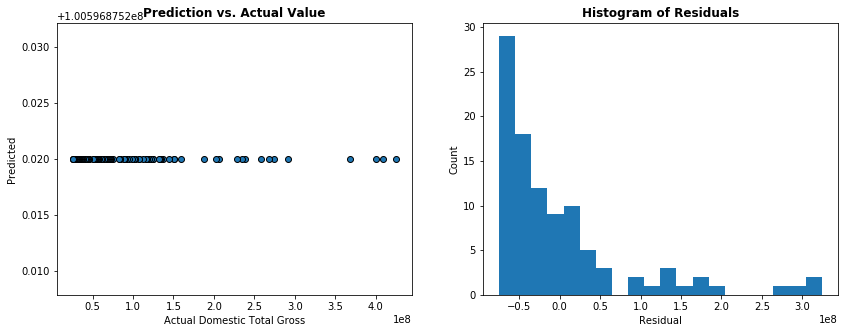

In [78]:
yp = lr.predict(X)
res = y-yp
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(14,5))
ax[0].scatter(y, yp, edgecolors=(0, 0, 0))
ax[0].set_xlabel('Actual Domestic Total Gross')
ax[0].set_ylabel('Predicted')
ax[0].set_title('Prediction vs. Actual Value',fontweight='bold')

ax[1].hist(res,bins=20);
ax[1].set_xlabel('Residual')
ax[1].set_ylabel('Count')
ax[1].set_title('Histogram of Residuals',fontweight='bold');


### Challenge 2
#### Repeat the process of challenge one, but also add one continuous (numeric) predictor variable. Also add plots of model prediction against your feature variable and residuals against feature variable. How can you interpret what's happening in the model?

<font color='blue'>Answer:

The feature "Budget" is added to the model and explains a small portion of the variance in Domestic Total Gross ($R^2=0.286$) with statistical significance ($P<0.0000005$). The distributation of the residuals looks more like normal distribution now.

In [166]:
data = df.dropna(subset=['Budget'])

# Create an empty model
lr = LinearRegression()

X = data[['Budget','const']]
y = data['DomesticTotalGross']

# Fit the model to the full dataset
lr.fit(X, y)

print('Fit score (R^2): %f'%lr.score(X,y))
for col in X:
    pval=f_select.f_regression(X[col].values.reshape(-1,1),y)[1]
    print('P-value, %s: %f'%(col,pval))

Fit score (R^2): 0.285814
P-value, Budget: 0.000000
P-value, const: nan


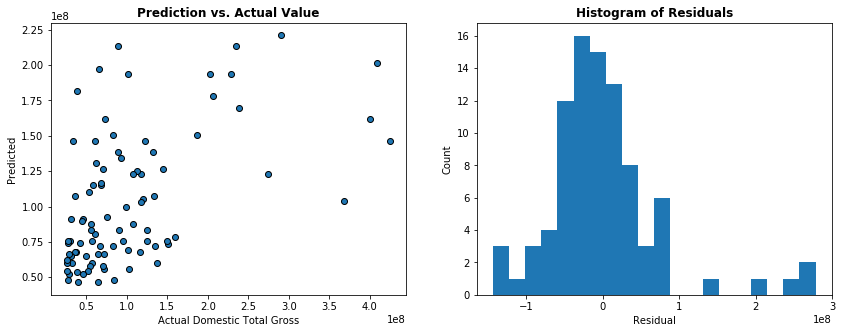

In [82]:
yp = lr.predict(X)
res = y-yp
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(14,5))
ax[0].scatter(y, yp, edgecolors=(0, 0, 0))
ax[0].set_xlabel('Actual Domestic Total Gross')
ax[0].set_ylabel('Predicted')
ax[0].set_title('Prediction vs. Actual Value',fontweight='bold')

ax[1].hist(res,bins=20);
ax[1].set_xlabel('Residual')
ax[1].set_ylabel('Count')
ax[1].set_title('Histogram of Residuals',fontweight='bold');

### Challenge 3
#### Repeat the process of challenge 1, but add a categorical feature (like genre). You'll have to convert a column of text into a number of numerical columns ("dummy variables"). How can you interpret what's happening in the model?

<font color='blue'>Answer:

Each category (minus 1, which becomes the "intercept") in the categorial feature (movie rating) becomes an individul feature with binary values. Adding these features explains about 11% of the variation in the response variable ("DomesticTotalGross").

In [86]:
df['Rating'].value_counts()

100

In [167]:
X=patsy.dmatrix('Rating',data=df,return_type='dataframe')

data = df[['DomesticTotalGross','const']].join(X)

lr = LinearRegression()
X = data.iloc[:,1:]
y = data['DomesticTotalGross']
lr.fit(X, y)

print('Fit score (R^2): %f'%lr.score(X,y))
for col in X:
    pval=f_select.f_regression(X[col].values.reshape(-1,1),y)[1]
    print('P-value, %s: %f'%(col,pval))

Fit score (R^2): 0.109229
P-value, const: nan
P-value, Intercept: nan
P-value, Rating[T.PG]: 0.142984
P-value, Rating[T.PG-13]: 0.244199
P-value, Rating[T.R]: 0.006471


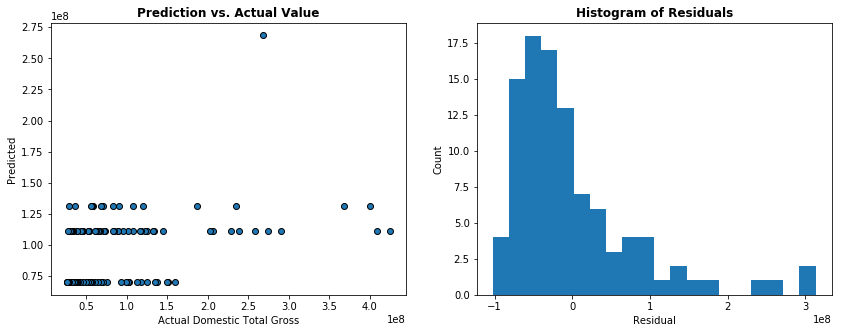

In [105]:
yp = lr.predict(X)
res = y-yp
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(14,5))
ax[0].scatter(y, yp, edgecolors=(0, 0, 0))
ax[0].set_xlabel('Actual Domestic Total Gross')
ax[0].set_ylabel('Predicted')
ax[0].set_title('Prediction vs. Actual Value',fontweight='bold')

ax[1].hist(res,bins=20);
ax[1].set_xlabel('Residual')
ax[1].set_ylabel('Count')
ax[1].set_title('Histogram of Residuals',fontweight='bold');

### Challenge 4
#### Enhance your model further by adding more features and/or transforming existing features. Think about how you build the model matrix and how to interpret what the model is doing.

In [106]:
df.columns

Index(['Title', 'Budget', 'DomesticTotalGross', 'Director', 'Rating',
       'Runtime', 'ReleaseDate', 'const'],
      dtype='object')

In [130]:
# Transform "ReleaseDate" to days since released (use end of 2017)
from datetime import datetime
def find_lapse(release_day):
    d1 = datetime.strptime(release_day, "%Y-%m-%d %H:%M:%S")
    d0 = datetime.strptime('2017-12-31', "%Y-%m-%d")
    delta = d0-d1
    return(delta.days)
df['days'] = df.ReleaseDate.apply(find_lapse)

In [168]:
# Transform "DomesticTotalGross" and "Budget" to log()
data = df.dropna(subset=['Budget'])
data['logDTG'] = data.DomesticTotalGross.apply(np.log)
data['logBGT'] = data.Budget.apply(np.log)

X=patsy.dmatrix('Rating',data=df,return_type='dataframe')
data = data[['logDTG','logBGT','Runtime','days']].join(X)
data.head()

,logDTG,logBGT,Runtime,days,Intercept,Rating[T.PG],Rating[T.PG-13],Rating[T.R]
0,19.866818,18.683045,146,1500,1.0,0.0,1.0,0.0
1,19.829260,19.113828,129,1703,1.0,0.0,1.0,0.0
2,19.808818,18.826146,108,1500,1.0,1.0,0.0,0.0
3,19.723760,18.146244,98,1642,1.0,1.0,0.0,0.0
4,19.488990,19.231611,143,1661,1.0,0.0,1.0,0.0


In [169]:
lr = LinearRegression()
X = data.iloc[:,1:]
y = data['logDTG']
lr.fit(X, y)

print('Fit score (R^2): %f'%lr.score(X,y))
for col in X:
    pval=f_select.f_regression(X[col].values.reshape(-1,1),y)[1]
    print('P-value, %s: %f'%(col,pval))

Fit score (R^2): 0.290871
P-value, logBGT: 0.000000
P-value, Runtime: 0.007386
P-value, days: 0.708751
P-value, Intercept: nan
P-value, Rating[T.PG]: 0.230167
P-value, Rating[T.PG-13]: 0.190525
P-value, Rating[T.R]: 0.021151


In [170]:
# Create your model
model = sm.OLS(y, X)

# Fit your model to your training set
fit = model.fit()

# Print summary statistics of the model's performance
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 logDTG   R-squared:                       0.291
Model:                            OLS   Adj. R-squared:                  0.248
Method:                 Least Squares   F-statistic:                     6.809
Date:                Sun, 28 Jan 2018   Prob (F-statistic):           2.29e-05
Time:                        16:04:49   Log-Likelihood:                -80.180
No. Observations:                  89   AIC:                             172.4
Df Residuals:                      83   BIC:                             187.3
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
logBGT              0.3009      0.082      3.650      0.000       0.137       0.465
Runtime             0.0073      0.005      1.605      0.112      -0.002       0.016
days                0.0006      0.001      0.943      0.348      -0.001       0.002
Intercept           8.2697      1.260      6.563      0.000       5.763      10.776
Rating[T.PG]        2.8954      0.454      6.383      0.000       1.993       3.798
Rating[T.PG-13]     2.6998      0.448      6.022      0.000       1.808       3.591
Rating[T.R]         2.6745      0.403      6.636      0.000       1.873       3.476
==============================================================================
Omnibus:                        3.722   Durbin-Watson:                   0.734
Prob(Omnibus):                  0.156   Jarque-Bera (JB):                2.626
Skew:                           0.257   Prob(JB):                        0.269
Kurtosis:                       2.333   Cond. No.                     2.35e+19
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 4.29e-31. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

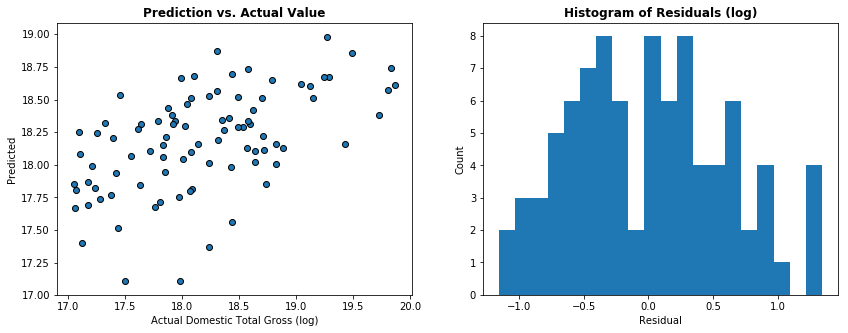

In [138]:
yp = lr.predict(X)
res = y-yp
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(14,5))
ax[0].scatter(y, yp, edgecolors=(0, 0, 0))
ax[0].set_xlabel('Actual Domestic Total Gross (log)')
ax[0].set_ylabel('Predicted')
ax[0].set_title('Prediction vs. Actual Value',fontweight='bold')

ax[1].hist(res,bins=20);
ax[1].set_xlabel('Residual')
ax[1].set_ylabel('Count')
ax[1].set_title('Histogram of Residuals (log)',fontweight='bold');

### Challenge 5
#### Fitting and checking predictions on the exact same data set can be misleading. Divide your data into two sets: a training and a test set (roughly 75% training, 25% test is a fine split). Fit a model on the training set, check the predictions (by plotting versus actual values) in the test set.

In [156]:
lr = LinearRegression()
# INSTRUCTOR NOTE: Run this multiple times to show the variation
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=4444,test_size=0.3)
# Fit the model against the training data
lr.fit(X_train, y_train)
# Evaluate the model against the testing data
lr.score(X_test, y_test)

0.19603255219091953

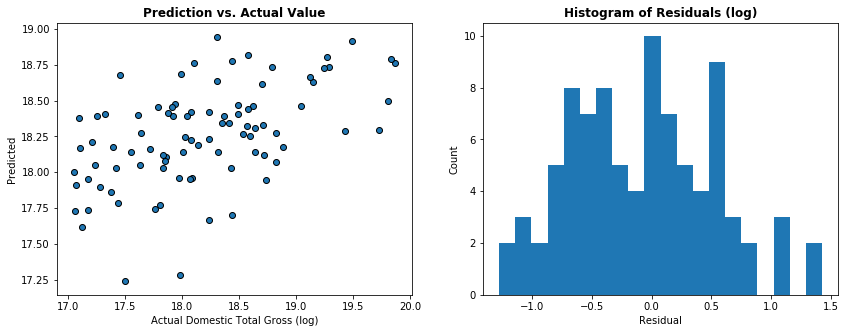

In [164]:
yp = lr.predict(X)
res = y-yp
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(14,5))
ax[0].scatter(y, yp, edgecolors=(0, 0, 0))
ax[0].set_xlabel('Actual Domestic Total Gross (log)')
ax[0].set_ylabel('Predicted')
ax[0].set_title('Prediction vs. Actual Value',fontweight='bold')

ax[1].hist(res,bins=20);
ax[1].set_xlabel('Residual')
ax[1].set_ylabel('Count')
ax[1].set_title('Histogram of Residuals (log)',fontweight='bold');

In [163]:
from sklearn.cross_validation import cross_val_score
from sklearn import metrics

# scores = cross_val_score(lr, X, y, cv=3, scoring='mean_squared_error')
scores = cross_val_score(lr, X, y, cv=3, scoring='r2')

# scores output is negative, a sklearn quirk bc mse is used to min. optimization func.
print(scores)

[ -6.1382104  -11.26825981 -13.72033581]
